### Pre Exercise Work
Working through chapter 13 to prepare for the chapter end exercise. 

In [3]:
import thinkstats2
import thinkplot

In [4]:
import numpy as np
import pandas as pd

In [21]:
import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query("outcome in [1, 3, 4]").prglngth
cdf = thinkstats2.Cdf(complete, label="cdf")

C:\Users\chris\MyNewJNFolder\thinkstats2.py:161: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self.d.update(obj.value_counts().iteritems())


In [25]:
def MakeSurvivalFromCdf(cdf, label=""):
    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)

In [66]:
sf = MakeSurvivalFromCdf(cdf, label="survived")

In [29]:
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


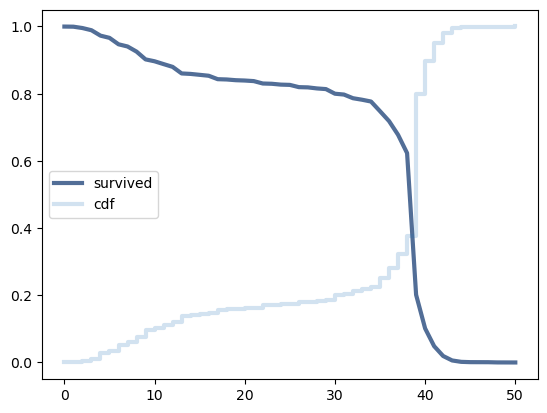

In [67]:
thinkplot.Plot(sf)
thinkplot.Cdf(cdf, alpha=0.2)
thinkplot.Config(loc="center left")

In [68]:
hf = sf.MakeHazardFunction(label="hazards")
print(hf[39])

0.6767068273092369


C:\Users\chris\MyNewJNFolder\survival.py:71: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=self.ts)


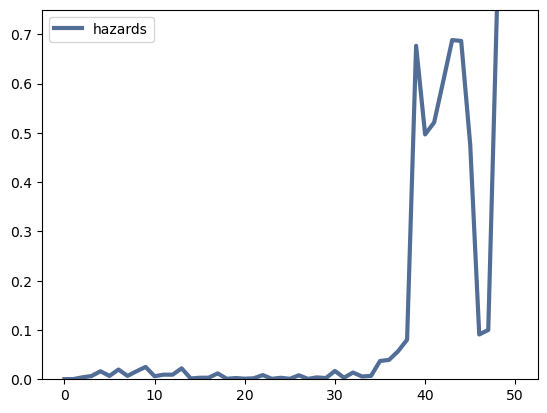

In [69]:
thinkplot.Plot(hf)
thinkplot.Config(ylim=[0, 0.75], loc="upper left")

In [33]:
resp6 = nsfg.ReadFemResp()

In [34]:
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0

In [35]:
complete = resp6[resp6.evrmarry == 1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry == 0].age

In [36]:
from collections import Counter


def EstimateHazardFunction(complete, ongoing, label="", verbose=False):
    if np.sum(np.isnan(complete)):
        raise ValueError("complete contains NaNs")
    if np.sum(np.isnan(ongoing)):
        raise ValueError("ongoing contains NaNs")

    hist_complete = Counter(complete)
    hist_ongoing = Counter(ongoing)

    ts = list(hist_complete | hist_ongoing)
    ts.sort()

    at_risk = len(complete) + len(ongoing)

    lams = pd.Series(index=ts, dtype=float)
    for t in ts:
        ended = hist_complete[t]
        censored = hist_ongoing[t]

        lams[t] = ended / at_risk
        if verbose:
            print(t, at_risk, ended, censored, lams[t])
        at_risk -= ended + censored

    return survival.HazardFunction(lams, label=label)

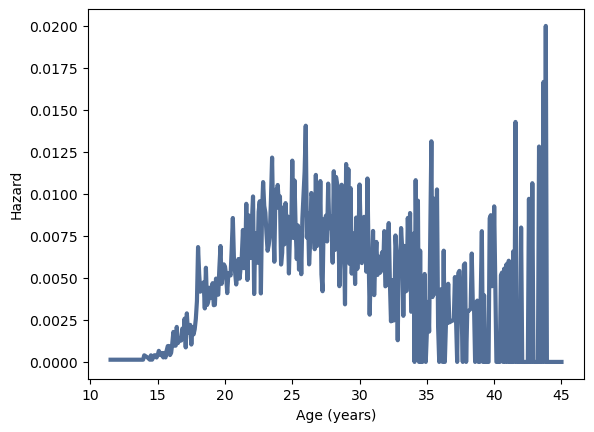

In [37]:
hf = EstimateHazardFunction(complete, ongoing)
thinkplot.Plot(hf)
thinkplot.Config(xlabel="Age (years)", ylabel="Hazard")

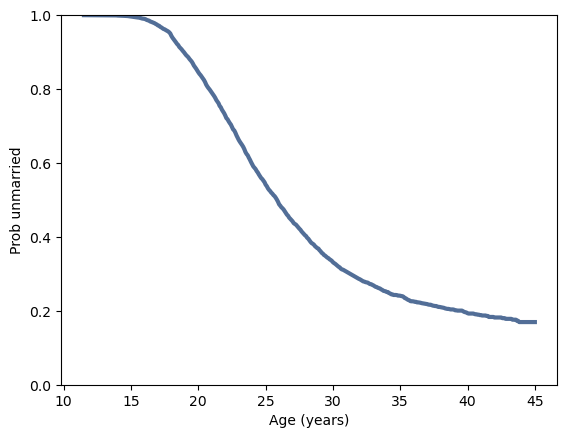

In [38]:
sf = hf.MakeSurvival()
thinkplot.Plot(sf)
thinkplot.Config(xlabel="Age (years)", ylabel="Prob unmarried", ylim=[0, 1])

In [39]:
def EstimateMarriageSurvival(resp):

    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age

    hf = EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [40]:
def ResampleSurvival(resp, iters=101):

    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)

    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1 / 12.0)

    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))

    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color="gray", label="90% CI")

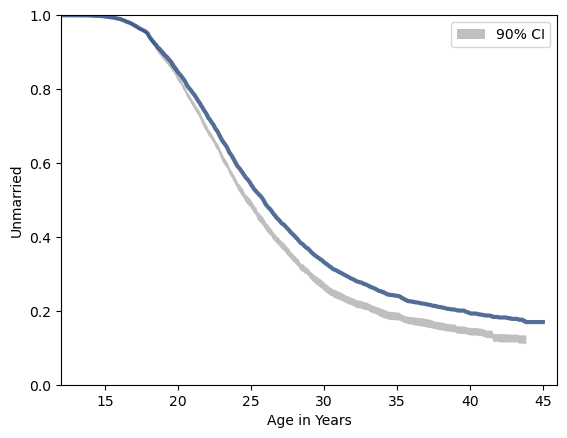

In [70]:
ResampleSurvival(resp6)
thinkplot.Config(
    xlabel="Age in Years",
    ylabel="Unmarried",
    xlim=[12, 46],
    ylim=[0, 1],
    loc="upper right",)

In [8]:
#Dumping Response Data to variables 

resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

,cmintvw,timesmar,cmmarrhx,cmbirth,finalwgt,evrmarry,agemarry,age,year,decade,fives
0,1149,NaN,NaN,837,6776.3796,False,NaN,26.000000,69,6,13
1,1142,1.0,1024.0,781,841.8221,True,20.250000,30.083333,65,6,13
2,1145,NaN,NaN,907,3617.3637,False,NaN,19.833333,75,7,15
3,1145,1.0,1133.0,771,10788.1271,True,30.166667,31.166667,64,6,12
4,1144,NaN,NaN,927,5359.4150,False,NaN,18.083333,77,7,15
...,...,...,...,...,...,...,...,...,...,...,...
10842,1143,1.0,929.0,719,2035.0909,True,17.500000,35.333333,59,5,11
10843,1144,1.0,910.0,625,3349.2418,True,23.750000,43.250000,52,5,10
10844,1141,1.0,1124.0,842,5487.1948,True,23.500000,24.916667,70,7,14
10845,1142,NaN,NaN,743,6471.3895,False,NaN,33.250000,61,6,12


In [14]:
resps = [resp5, resp6, resp7]

In [19]:
def AddLabelsByDecade(groups, **options):
    thinkplot.PrePlot(len(groups))
    for name, _ in groups:
        label = "%d0s" % name
        thinkplot.Plot([15], [1], label=label, **options)


def EstimateMarriageSurvivalByDecade(groups, **options):

    thinkplot.PrePlot(len(groups))
    for _, group in groups:
        _, sf = EstimateMarriageSurvival(group)
        thinkplot.Plot(sf, **options)


def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):

    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")

        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]

        if i == 0:
            AddLabelsByDecade(groups, alpha=0.7)

        if predict_flag:
            PlotPredictionsByDecade(groups, alpha=0.1)
            EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

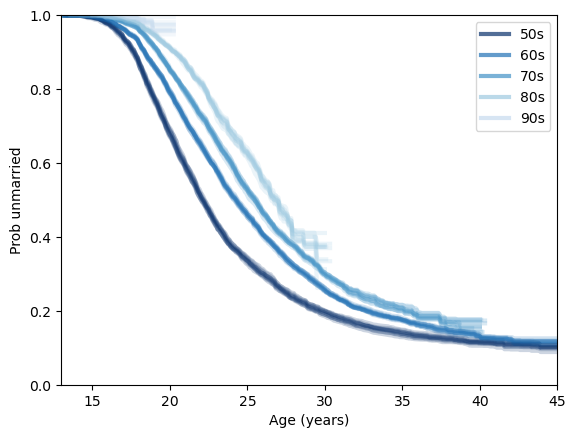

In [44]:
PlotResampledByDecade(resps)
thinkplot.Config(
    xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1])

In [45]:
def PlotPredictionsByDecade(groups, **options):

    hfs = []
    for _, group in groups:
        hf, sf = EstimateMarriageSurvival(group)
        hfs.append(hf)

    thinkplot.PrePlot(len(hfs))
    for i, hf in enumerate(hfs):
        if i > 0:
            hf.Extend(hfs[i - 1])
        sf = hf.MakeSurvival()
        thinkplot.Plot(sf, **options)

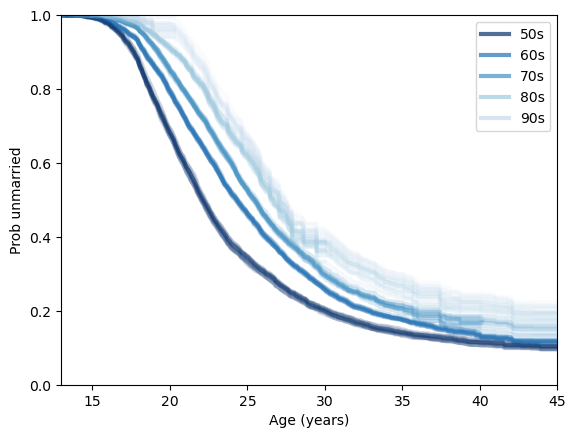

In [47]:
PlotResampledByDecade(resps, predict_flag=True)
thinkplot.Config(
    xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1])

In [48]:
preg = nsfg.ReadFemPreg()

complete = preg.query("outcome in [1, 3, 4]").prglngth
print("Number of complete pregnancies", len(complete))
ongoing = preg[preg.outcome == 6].prglngth
print("Number of ongoing pregnancies", len(ongoing))

hf = EstimateHazardFunction(complete, ongoing)
sf1 = hf.MakeSurvival()

Number of complete pregnancies 11189
Number of ongoing pregnancies 352


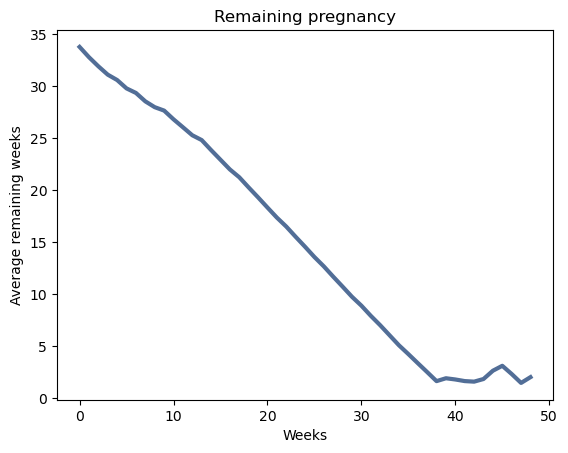

In [52]:
rem_life1 = sf1.RemainingLifetime()
thinkplot.Plot(rem_life1)
thinkplot.Config(
    title="Remaining pregnancy", xlabel="Weeks", ylabel="Average remaining weeks")

In [53]:
hf, sf2 = EstimateMarriageSurvival(resp6)

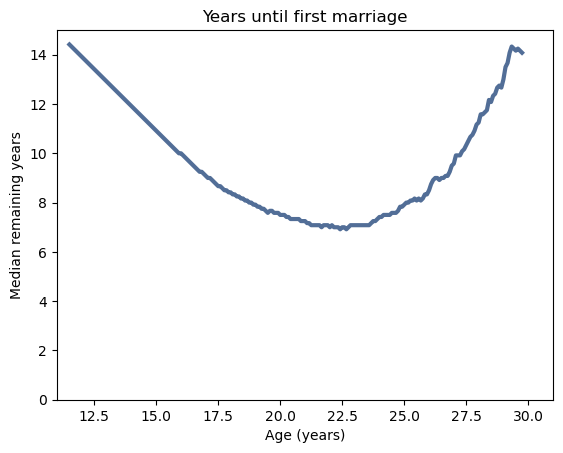

In [54]:
func = lambda pmf: pmf.Percentile(50)
rem_life2 = sf2.RemainingLifetime(filler=np.inf, func=func)

thinkplot.Plot(rem_life2)
thinkplot.Config(
    title="Years until first marriage",
    ylim=[0, 15],
    xlim=[11, 31],
    xlabel="Age (years)",
    ylabel="Median remaining years",)

### Begin 13.1 Exercise

In [55]:
#Trying out a cleaning function. Did not work the first time. 

def CleanData(resp):
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [56]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [57]:
def ResampleDivorceCurve(resps):

    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [63]:
def ResampleDivorceCurveByDecade(resps):

    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Undivorced", axis=[0, 28, 0, 1])

In [59]:
def EstimateSurvivalByDecade(groups, **options):

    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [64]:
def EstimateSurvival(resp):

    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

In [71]:
def main():
    resp6 = survival.ReadFemResp2002()
    CleanData(resp6)
    married6 = resp6[resp6.evrmarry==1]

    resp7 = survival.ReadFemResp2010()
    CleanData(resp7)
    married7 = resp7[resp7.evrmarry==1]

    ResampleDivorceCurveByDecade([married6, married7])

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

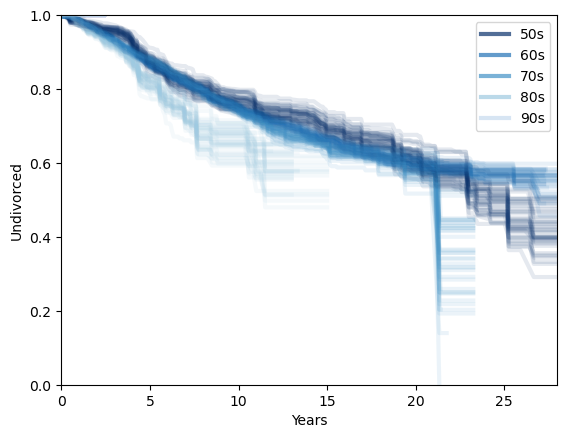

In [72]:
main()

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  lams = pd.Series(index=ts)
C:\Users\chris\MyNewJNFolder\survival.py:300: FutureWarn

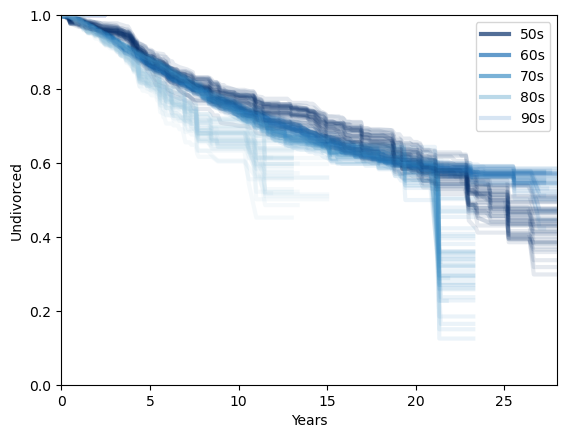

In [65]:
# Not able to resolve warnings. 

ResampleDivorceCurveByDecade([married6, married7])